<figure>
<img src="../imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Minicurso  de Inteligencia Artificial<center></span>

## <span style="color:Green"><center>Clasificación con redes neuronales<center></span>

##   <span style="color:blue">Profesores</span>

1. Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
2. Daniel  Montenegro, Msc, dextronomo@gmail.com 
1. Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

1. Nayibe Yesenia Arias, naariasc@unal.edu.co
1. Venus Celeste Puertas, vpuertasg@unal.edu.co 

In [1]:
import torch
from torch import nn
from torch.nn import functional
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from torch.nn import Flatten, Sequential, Linear, ReLU

In [2]:

training_data = datasets.FashionMNIST(
    root="/media/storage/Datasets", #recuerden cambiar donde quieren que se descarguen los datos
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="/media/storage/Datasets",
    train=False,
    download=True,
    transform=ToTensor(),
)

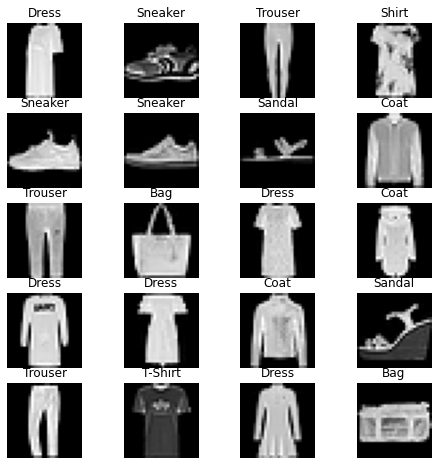

In [3]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(training_data));
    img = training_data[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[training_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
batch_size = 32

#crea data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print('X[N, C, H, W]: ', X.shape)
    print('Shape of y: ', y.shape, y.dtype)
    break

X[N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64


In [5]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6,
                            kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=12,
                            kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = functional.relu(x)
        x = functional.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = functional.relu(x)
        x = functional.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.reshape(-1, 12*4*4)
        x = self.fc1(x)
        x = functional.relu(x)
        
        x = self.fc2(x)
        x = functional.relu(x)
        
        x = self.out(x)
        
        return x
    
model = CNNNetwork()
print(model)

CNNNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [6]:
from datetime import datetime

class Trainer:
    def __init__(self, model, loss_fn, optimizer, metrics=None,
                metric_names=None,
                writer=None, path_to_save='',
                learning_rate=1e-3,
                batch_size=64,
                epochs=5, n_report=1000):
        
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self.metrics_train = metrics
        self.metrics_valid = self.metrics_train.copy()
        self.metric_names = metric_names
        
        self.writer = writer
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.n_report = n_report
        
        self.path_to_save = path_to_save
        self.best_model = None
        
        self.training_loader = None
        
        self.validation_loader = None
        
    
    def set_model(self, model):
        self.model = model
        
    def set_loss(self, loss):
        self.loss = loss
        
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def set_writer(self, writer):
        self.writer =  writer
    # getters
    def get_model(self):
        return self.model
    
    
    def set_hiperparameters(self,
                 learning_rate = 1e-3,
                 batch_size = 64,
                 epochs = 5):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs        
    
    
    
    def _train_one_epoch_(self, epoch_index):
        
        running_loss = 0.
        las_loss = 0.
        
        for i, data in enumerate(self.training_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs) #no necesitamos usar softmax
            
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            
            self.optimizer.step()
            
            running_loss += loss.item()
            running_metrics = self._metric_step_(outputs, labels, metric_compute=False, 
                                          validation=False)
            
            if i % self.n_report == (self.n_report-1):
                last_loss = running_loss / self.n_report
                running_loss = 0.
                last_metrics = self._metric_step_(None, None, metric_compute=True, 
                                          validation=False)
                
                print('Pérdida en el lote {} : {}'.format(i + 1, last_loss))
                
                print_m = ''
                for j in range(len(metrics)):
                    print_m += self.metric_names[j] + ': ' + str(last_metrics[j]) + ' '
                print('Métricas en el lote {} : {}'.format(i + 1, print_m))
                
                if self.writer is not None:
                    tb_x = epoch_index * len(training_loader) + i + 1
                    # pérdida
                    self.writer.add_scalar('Pérdida/Entrenamiento', last_loss, tb_x)
                    # métricas
                    for i in range(len(last_metric)):
                        self.writer.add_scalar(self.metric.names[i] + '/Entrenamiento', 
                                               last_metrics[i], tb_x)
    
    
    def _validation_step_(self, validation=True):
        if validation:
            data_loader = self.validation_loader
        else:
            data_loader = self.training_loader
            
        running_vloss = 0.0
        for i, vdata in enumerate(data_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = self.model(vinputs)
            vloss = self.loss_fn(voutputs, vlabels)
            
            running_vloss += vloss
            _  = self._metric_step_(voutputs, vlabels, 
                            metric_compute=False, validation= validation)

        avg_vloss = running_vloss / (i + 1)
        v_metrics =   self._metric_step_(None, None, metric_compute=True, 
                                          validation= validation)
        
        return avg_vloss, v_metrics
    
    def _metric_step_(self, predicts, labels, metric_compute=False, validation=False):
          
                
        if validation:
            metrics = self.metrics_valid
        else:
            metrics = self.metrics_train
        
        if predicts is not None and labels is not None:
            for i, metric in enumerate(metrics):
                metrics[i].to(device)
                metrics[i].update(predicts, labels)
        
        if metric_compute:
            values = [metric.compute().item() for metric in metrics]
            for metric in metrics:
                metric.reset() 
        else:
            values = [metric(predicts, labels).item() for metric in metrics]
    
        return values
    
    def _train_loop_(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        epoch_number = 0

        best_vloss = 1_000_000.
        
        
        for epoch in range(self.epochs):
            print('época {}:'.format(epoch_number + 1))
            
            model.train(True)
            self._train_one_epoch_(epoch_number)

            self.model.train(False)
            
            e_loss, e_metrics = self._validation_step_(validation=False)
            v_loss, v_metrics = self._validation_step_(validation=True)
            
            print('Pérdida entrenamiento: {}, validación {}'.format(e_loss, v_loss))
            
            print_m_e = ''
            for i in range(len(e_metrics)):
                print_m_e += self.metric_names[i] + ': ' + str(e_metrics[i]) + ' '
            print_m_v = ''
            for i in range(len(v_metrics)):
                print_m_v += self.metric_names[i] + ': ' + str(v_metrics[i]) + ' '     
            print('Métricas en entrenamiento : {}, validación {} '.format(print_m_e, print_m_v))
            
            
            if self.writer is not None:
                self.writer.add_scalars('Pérdida entrenamiento v.s. Pérdida validación',
                                { 'Entrenamiento' : e_loss, 'Validación' : e_vloss },
                                epoch_number + 1)
                
                for i in range(len(e_metrics)):  
                    self.writer.add_scalars(self.metric.names[i] + 'entrenamiento v.s. validación',
                                { 'Entrenamiento' : e_metrics[i], 'Validación' : v_metrics[i] },
                                epoch_number + 1)
                  
                self.writer.flush()
                
            if  v_loss < best_vloss:
                best_vloss = v_loss
                model_path = self.path_to_save + 'model_{}_{}'.format(timestamp, epoch_number)
                torch.save(model.state_dict(), model_path)
                self.path_best_model = model_path

            epoch_number += 1 
            
            
    def fit(self, train_data, val_data, epochs=None, writer=None, best_loss=True):
        if writer is not None:
            self.writer = writer
        if epochs is not None:
            self.epochs = epochs
            
        self.training_loader = train_data
        self.validation_loader = val_data
        
        self._train_loop_()
        
        if best_loss:
            self.model.load_state_dict(torch.load(self.path_best_model))

            

In [7]:
class Data():

    def __init__(self, dataset=None, batch_size=64, shuffle=True):    
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self._data = DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
    
    def get_data(self):
        return self._data
    
    def set_data(self, dataset):
        self._dataset = dataset
        self._data = DataLoader(self._dataset, batch_size=self.batch_size, shuffle=self.shuffle)
    
    data = property(get_data, set_data)
    
    def __len__(self):
        return len(self._data)

In [8]:
class Drawer:
    def __init__(self, dataset, label_names, rows=5, columns=4, figsize=(8,8)):
        
        self.dataset = dataset
        self.label_names = label_names
        self.rows = rows
        self.columns = columns
        self.figsize = figsize
    
    def plot(self):
        fig = plt.figure(figsize=self.figsize);
        
        for i in range(1, self.columns * self.rows +1):
            img_xy = np.random.randint(len(self.dataset));
            img = self.dataset[img_xy][0][0,:,:]
            fig.add_subplot(self.rows, self.columns, i)
            plt.title(labels_map[self.dataset[img_xy][1]])
            plt.axis('off')
            plt.imshow(img, cmap='gray')
        plt.show()
    

In [9]:
transform = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,))])

train_data = datasets.FashionMNIST(
    root="/media/storage/Datasets",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="/media/storage/Datasets",
    train=False,
    download=True,
    transform=transform
)

train = Data(train_data, batch_size=32)
validation = Data(test_data, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using {} device'.format(device))

model = CNNNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

metrics = [Accuracy()]
metric_names = ['Exactitud']
path_to_save = '../Modelos/'

trainer = Trainer(model=model, loss_fn=loss_fn,  
                  optimizer=optimizer, metrics=metrics, 
                  metric_names = metric_names,
                  n_report=375, path_to_save= path_to_save )

using cuda device


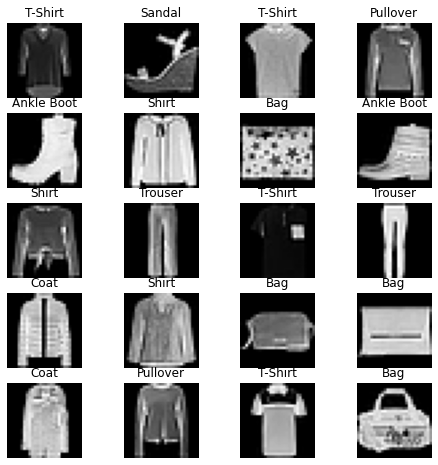

In [10]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

test_data = datasets.FashionMNIST(
    root="/media/storage/Datasets",
    train=False,
    download=True,
    transform=ToTensor(),
)

drawer = Drawer(dataset=test_data, label_names=labels_map)
drawer.plot()

In [11]:
trainer.fit(train.data, validation.data)

época 1:
Pérdida en el lote 375 : 0.8884229316711426
Métricas en el lote 375 : Exactitud: 0.6600000262260437 
Pérdida en el lote 750 : 0.617433112025261
Métricas en el lote 750 : Exactitud: 0.7582499980926514 
Pérdida en el lote 1125 : 0.5259208819071451
Métricas en el lote 1125 : Exactitud: 0.8003333210945129 
Pérdida en el lote 1500 : 0.4876894668340683
Métricas en el lote 1500 : Exactitud: 0.8164166808128357 
Pérdida en el lote 1875 : 0.465487664103508
Métricas en el lote 1875 : Exactitud: 0.8264166712760925 
Pérdida entrenamiento: 0.4132314622402191, validación 0.44537675380706787
Métricas en entrenamiento : Exactitud: 0.8464166522026062 , validación Exactitud: 0.8331000208854675  
época 2:
Pérdida en el lote 375 : 0.44367561481396356
Métricas en el lote 375 : Exactitud: 0.8319166898727417 
Pérdida en el lote 750 : 0.41351888970534006
Métricas en el lote 750 : Exactitud: 0.8479999899864197 
Pérdida en el lote 1125 : 0.4008974309166273
Métricas en el lote 1125 : Exactitud: 0.8510833